# Find Market Mispricings Like The Pros With GARCH

Professional options traders don’t make bets that stocks will go up or down. They look for mispricings in the market. Mispricing happens when the market price is different than what a model says the price should be.

If the price of an option is \\$1.50 and the model shows it should be \\$1.75, a trader would buy the option “cheap” and wait for it to rise to \\$1.75.

Derivatives models use volatility to determine the value. So quants spend most of their time building the best volatility forecasts they can to find market mispricings. If you’re interested in using [Python](https://pyquantnews.com/python/) to price options, you might like my [ebook](https://pyquantnews.gumroad.com/l/46-page-ultimate-guide-pricing-options-implied-volatility-python-pdf-code-pyquant-news).

And you can use the same tools as the quants.

## GARCH Is Widely Viewed As A Better Gauge Of Volatility Than The Standard Deviation

Stock returns have two interesting features that GARCH models well:

1. Variance error terms are autocorrelated (dependent on each other)
2. Periods of high volatility tend to cluster
Dr. Tim Bollerslev developed GARCH in 1986 to address the problem of forecasting volatility in asset prices. It’s used in quant finance for risk management, derivatives pricing, and portfolio optimization.

Here's what we'll do:

1. Get stock price data
2. Fit a GARCH model
3. Forecast volatility
4. Find mispricings

## Step 1: Get Stock Price Data
Start by importing the libraries and getting the data. I like to use yfinance for getting stock data and NumPy for math functions. I use the excellent library [arch](https://arch.readthedocs.io/en/latest/univariate/introduction.html) to forecast volatility.

To control plot formatting, set options like figure size and font.

In [1]:
import numpy as np
from openbb_terminal.sdk import openbb
from arch import arch_model

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

After the imports, grab some data.



In [3]:
data = openbb.stocks.load("TLT", start_date="2020-01-01", end_date="2022-07-31")

Loading Daily data for TLT with starting period 2020-01-02.

Compute the simple returns and multiply by 100 to avoid the scaling warning from arch_model.

In [4]:
adjusted_closes = data['Adj Close']
returns = 100 * adjusted_closes.pct_change().dropna()

## Step 2: Fit A GARCH Model
Fitting a GARCH model is one line of code.



In [5]:
model = arch_model(returns)

Calling arch_model like this does three things:

1. Uses a constant mean
2. Assumes a GARCH(1, 0, 1) volatility model
3. Uses a normal distribution for the standardized errors

You can adjust these values – and even build your own mean and variance models – as inputs. Check out the [documentation](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html) if you’re interested.

After you define the model, fit it.

In [6]:
res = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6759626056.819712
Iteration:      2,   Func. Count:     14,   Neg. LLF: 923364555.8747447
Iteration:      3,   Func. Count:     21,   Neg. LLF: 183731167.56454018
Iteration:      4,   Func. Count:     27,   Neg. LLF: 930.5102679788781
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1871.8945326179091
Iteration:      6,   Func. Count:     39,   Neg. LLF: 924.4406809221178
Iteration:      7,   Func. Count:     45,   Neg. LLF: 916.1170794559937
Iteration:      8,   Func. Count:     51,   Neg. LLF: 916.0154437282715
Iteration:      9,   Func. Count:     57,   Neg. LLF: 916.0000104589019
Iteration:     10,   Func. Count:     62,   Neg. LLF: 915.9999845232171
Iteration:     11,   Func. Count:     66,   Neg. LLF: 915.9999845235327
Optimization terminated successfully    (Exit mode 0)
            Current function value: 915.9999845232171
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 

The library uses an iterative algorithm called [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) to fit the model parameters. Details of each iteration prints to the screen.

## Step 3: Forecast Volatility
Now the model is fit. Check the summary.

In [7]:
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -916.000
Distribution:                  Normal   AIC:                           1840.00
Method:            Maximum Likelihood   BIC:                           1857.90
                                        No. Observations:                  648
Date:                Fri, Dec 23 2022   Df Residuals:                      647
Time:                        15:21:26   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.2755e-03  3.535e-02     -0.262      0.

It shows the statistical significance of each of the coefficients. They all have very small p-values. We can assume the results are not due to random chance.

You can visualize the standardized residuals and conditional volatility.

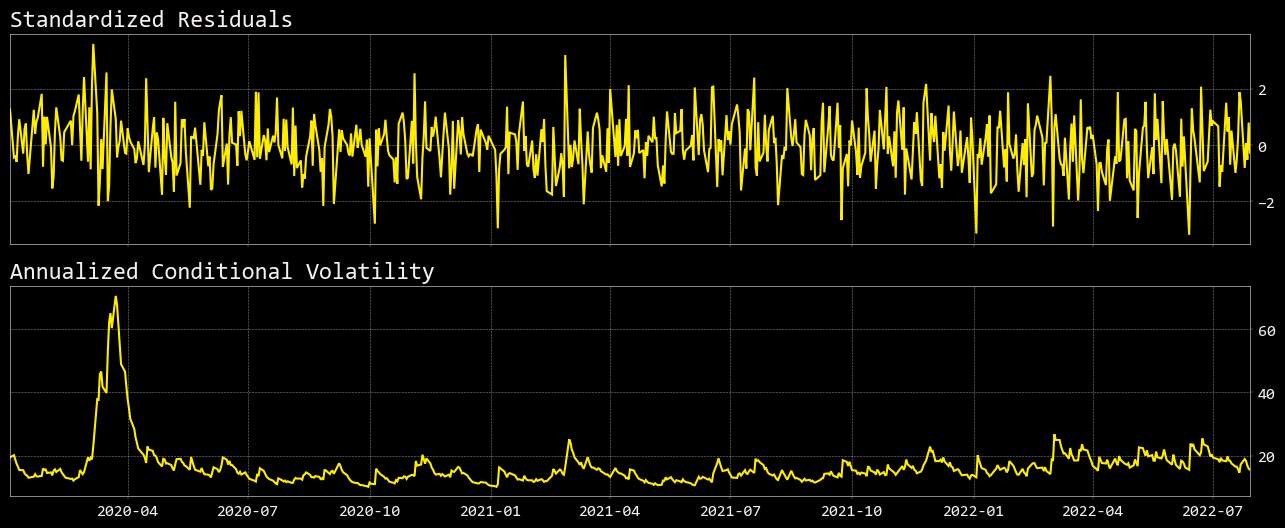

In [8]:
fig = res.plot("D")

Control the number of forecasts with the horizon argument. I use the first forecast in this example.

In [9]:
# get the variance forecast
forecast = res.forecast(horizon=1, reindex=False)
variance_forecast = forecast.variance.iloc[-1][0]

In [10]:
# compute the annualized volatility forecast
volatility_forecast = np.sqrt(variance_forecast)
annualized_volatility_forecast = volatility_forecast * np.sqrt(252) / 100
annualized_volatility_forecast

0.1459330525563052

In [11]:
annualized_volatility_stdev = returns.std() * np.sqrt(252) / 100
annualized_volatility_stdev

0.18412301781528537

In [12]:
(annualized_volatility_forecast-annualized_volatility_stdev)/annualized_volatility_stdev

-0.20741548619028632

The library returns the variance forecast. To convert that to a volatility number, take the sqaure root. Then annualize it.



## Step 3: Find A Mispricing
Compare the standard deviation of returns to the GARCH volatility forecast. There’s a 10.7% difference. Use an options calculator and value an option using both volatility inputs.



The value of a call option using the GARCH forecast for volatility is \\$10.12.



The value of a call option using historical volatility is \\$11.22.

If you believe the GARCH model is more accurate than the historical volatility in forecasting volatility, you’d sell this call option.